In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
import tensorflow as tf
import os

In [3]:
# generate mask based on .mat mask
def generate_mask_mat(mask=[], mute=0):
    # shift
    mask = np.fft.ifftshift(mask)
    # compute reduction
    r_factor = len(mask.flatten())/sum(mask.flatten())
    if not mute:
        print('load mask size of {1} for R-factor={0:.4f}'.format(r_factor, mask.shape))
    return mask, r_factor

In [4]:
path_mask = '/Users/enhao/Documents/Research/MRI/GANCS/data_MRI/sampling_pattern/mask_2dvardesnity_radiaview_4fold.mat'

In [5]:
from scipy import io as sio #.mat I/O

In [6]:
content_mask = sio.loadmat(path_mask)
key_mask = [x for x in content_mask.keys() if not x.startswith('_')]
mask = content_mask[key_mask[0]]

In [7]:
DEFAULT_MASK, r_factor = generate_mask_mat(mask)

load mask size of (200, 100) for R-factor=5.0000


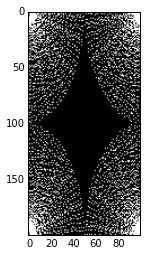

In [8]:
plt.imshow(DEFAULT_MASK,cmap='gray')

In [9]:
# convert to complex tf tensor
DEFAULT_MAKS_TF = tf.cast(tf.constant(DEFAULT_MASK), tf.float32)
DEFAULT_MAKS_TF_c = tf.cast(DEFAULT_MAKS_TF, tf.complex64)


In [10]:
sample_size=200
sample_size_y=100

In [11]:
image_size=None
if image_size is None:
    # image_size
    if sample_size_y>0:
        image_size = [sample_size, sample_size_y]
    else:
        image_size = [sample_size, sample_size]
image_size

[200, 100]

In [12]:
dir_input = '/Users/enhao/Documents/Research/MRI/GANCS/data_MRI/generated_slices_jpg'
filenames_input = [x for x in os.listdir(dir_input) if x.endswith('jpg')]

In [13]:
# Read each JPEG file
reader_input = tf.WholeFileReader()
filename_queue_input = tf.train.string_input_producer(filenames_input)
key, value_input = reader_input.read(filename_queue_input)
channels = 3
image_input = tf.image.decode_jpeg(value_input, channels=channels, name="input_image")
image_input.set_shape([None, None, channels])
image_input

<tf.Tensor 'input_image:0' shape=(?, ?, 3) dtype=uint8>

In [14]:
# cast image to float in 0~1
image_input = tf.cast(image_input, tf.float32)/255.0
# use the last channel (B) for input and output, assume image is in gray-scale
image_output = image_input[:,:,-1]
image_input = image_input[:,:,-1]

In [15]:
# apply undersampling mask
kspace_input = tf.fft2d(tf.cast(image_input,tf.complex64))
kspace_zpad = kspace_input * DEFAULT_MAKS_TF_c
# zpad undersampled image for input
image_zpad = tf.ifft2d(kspace_zpad)
image_zpad_real = tf.real(image_zpad)
image_zpad_real = tf.reshape(image_zpad_real, [image_size[0], image_size[1], 1])
image_zpad_imag = tf.imag(image_zpad)
image_zpad_imag = tf.reshape(image_zpad_imag, [image_size[0], image_size[1], 1])    
# concat to input, 2 channel for real and imag value
image_zpad_concat = tf.concat(2,[image_zpad_real, image_zpad_imag])

In [16]:
image_zpad_concat

<tf.Tensor 'concat:0' shape=(200, 100, 2) dtype=float32>

In [17]:
feature = tf.reshape(image_zpad_concat, [image_size[0], image_size[1], 2])
label   = tf.reshape(image_output, [image_size[0], image_size[1], 1])


In [19]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.1
sess = tf.Session(config = config)

In [36]:
array_feature = sess.run(feature)
array_label = sess.run(label)

InvalidArgumentError: No OpKernel was registered to support Op 'FFT2D' with these attrs.  Registered kernels:
  <no registered kernels>

	 [[Node: FFT2D_4 = FFT2D[](Cast_9)]]

Caused by op u'FFT2D_4', defined at:
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Library/Python/2.7/site-packages/IPython/kernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Library/Python/2.7/site-packages/IPython/config/application.py", line 574, in launch_instance
    app.start()
  File "/Library/Python/2.7/site-packages/IPython/kernel/zmq/kernelapp.py", line 373, in start
    ioloop.IOLoop.instance().start()
  File "/Library/Python/2.7/site-packages/zmq/eventloop/ioloop.py", line 151, in start
    super(ZMQIOLoop, self).start()
  File "/Library/Python/2.7/site-packages/tornado/ioloop.py", line 837, in start
    handler_func(fd_obj, events)
  File "/Library/Python/2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Library/Python/2.7/site-packages/zmq/eventloop/zmqstream.py", line 433, in _handle_events
    self._handle_recv()
  File "/Library/Python/2.7/site-packages/zmq/eventloop/zmqstream.py", line 465, in _handle_recv
    self._run_callback(callback, msg)
  File "/Library/Python/2.7/site-packages/zmq/eventloop/zmqstream.py", line 407, in _run_callback
    callback(*args, **kwargs)
  File "/Library/Python/2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Library/Python/2.7/site-packages/IPython/kernel/zmq/kernelbase.py", line 252, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Library/Python/2.7/site-packages/IPython/kernel/zmq/kernelbase.py", line 213, in dispatch_shell
    handler(stream, idents, msg)
  File "/Library/Python/2.7/site-packages/IPython/kernel/zmq/kernelbase.py", line 362, in execute_request
    user_expressions, allow_stdin)
  File "/Library/Python/2.7/site-packages/IPython/kernel/zmq/ipkernel.py", line 181, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Library/Python/2.7/site-packages/IPython/core/interactiveshell.py", line 2871, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Library/Python/2.7/site-packages/IPython/core/interactiveshell.py", line 2975, in run_ast_nodes
    if self.run_code(code, result):
  File "/Library/Python/2.7/site-packages/IPython/core/interactiveshell.py", line 3035, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-ec1581c22032>", line 2, in <module>
    kspace_input = tf.fft2d(tf.cast(image_input,tf.complex64))
  File "/Library/Python/2.7/site-packages/tensorflow/python/ops/gen_math_ops.py", line 819, in fft2d
    result = _op_def_lib.apply_op("FFT2D", input=input, name=name)
  File "/Library/Python/2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 749, in apply_op
    op_def=op_def)
  File "/Library/Python/2.7/site-packages/tensorflow/python/framework/ops.py", line 2380, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Library/Python/2.7/site-packages/tensorflow/python/framework/ops.py", line 1298, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): No OpKernel was registered to support Op 'FFT2D' with these attrs.  Registered kernels:
  <no registered kernels>

	 [[Node: FFT2D_4 = FFT2D[](Cast_9)]]


In [20]:
import json

In [21]:
dict_result = json.load(open('batch000125_test0.json','r'))

In [22]:
dict_result.keys()

[u'gene_layers', u'disc_layers', u'feature', u'gene_output', u'label']

In [41]:
feature_saved = np.array(dict_result['feature'])
label_saved = np.array(dict_result['label'])
gene_output = np.array(dict_result['gene_output'])

In [42]:
feature_saved.shape, label_saved.shape, gene_output.shape

((4, 200, 100, 2), (4, 200, 100, 1), (4, 200, 100, 1))

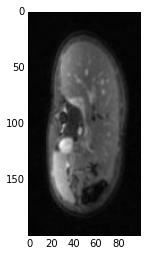

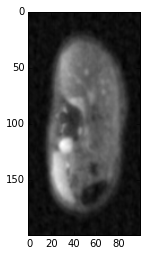

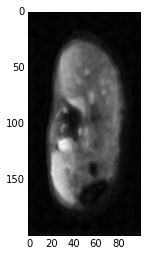

In [45]:
plt.figure()
plt.imshow(label_saved[3,:,:,0],cmap='gray')
plt.figure()
plt.imshow(feature_saved[3,:,:,0],cmap='gray')
plt.figure()
plt.imshow(gene_output[3,:,:,0],cmap='gray')

In [36]:
plt.imshow(label_saved[3,:,:,0],cmap='gray')

NameError: name 'label_saved' is not defined